In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from statannot import add_stat_annotation
matplotlib.rcParams['pdf.fonttype'] = 42

### dic interaction
dic_interaction = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Genes_specificity/gtex/robust_associations_exons_genes.txt") as file:
    for line in file:      
        if line.strip().split()[0] not in dic_interaction:
            dic_interaction[line.strip().split()[0]] = [line.strip().split()[1]]
        else:
            dic_interaction[line.strip().split()[0]].append(line.strip().split()[1])

### Load exon-to-biotype map
tmp_dic = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Genes_specificity/gtex/exons_BioGtex_majority_bilan.tsv") as file:
    for line in file:
        parts = line.strip().split()
        if parts[3] == "TRUE":
            tissue = parts[4]
            ee = parts[0]
            tmp_dic.setdefault(tissue, []).append(ee)

### ee_spec_wth_target
ee_to_plot_dic = {}
for key,val in tmp_dic.items():
    ee_to_plot_dic[key] = []
    for ee in val:
        if ee in dic_interaction:
            for target in dic_interaction[ee]:
                ee_to_plot_dic[key].append(target) 

### Load GTEx median TPM data
df_tmp = pd.read_csv('/home/mouren/Data/revisions/specificity/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct', sep='\t', header=0)
df_tmp = df_tmp[~df_tmp['Name'].str.contains("PAR_Y")]
df_tmp['Name_split'] = df_tmp['Name'].str.split('.').str.get(0)

# Now we can remove thoses two columns
column_exons_id = df_tmp.pop('Name')
column_gene_id = df_tmp.pop('Description')
column_gene_id2 = df_tmp.pop('Name_split')

## Normalize data
def normalize_row(row):
    row_mean = row.mean()
    row_std = row.std()
    row_normalized = (row - row_mean) / (row_std+1e-5) #to avoid dividing by zero
    #row_normalized = row/row_mean
    return row_normalized

df_gtex = df_tmp.apply(normalize_row, axis=1)
df_gtex["Gene"] = column_gene_id2

### Load transcript-to-gene mapping
dic_transcript_gene = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Conservation_and_structure/other_files/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:
        tx, gene = line.strip().split()[:2]
        dic_transcript_gene[tx] = gene.split(".")[0]

### Load GTEx simplified tissue type mapping
dic_gtex_simple = {}
with open("/mnt/project/exonhancer/ZENODO_REPO/Genes_specificity/gtex/gTEXBiotypess_Simplifie.csv") as file:
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            dic_gtex_simple[parts[0]] = parts[1]

# Reverse mapping: get all unique simplified tissue types
tissue_groups = set(dic_gtex_simple.values())

# Prepare division by number of gtex tissue mapped 
dic_division = {}
for val in dic_gtex_simple.values():
    if val not in dic_division:
        dic_division[val] = 1
    else:
        dic_division[val] += 1

### Main result dictionary
res_by_signature = {}

### Process all exon biotype groups
for signature, ee_list in ee_to_plot_dic.items():
    res_by_signature[signature] = {}
    for ee in ee_list:
        filtered_row = df_gtex[df_gtex['Gene'] == ee]
        if filtered_row.empty:
            continue
        entry = {group: None for group in tissue_groups}
        for col in filtered_row.columns:
            if col == "Gene":
                continue
            tissue_group = dic_gtex_simple.get(col)
            if tissue_group:
                value = filtered_row[col].values[0]
                if entry[tissue_group] is None:
                    entry[tissue_group] = value
                else:
                    entry[tissue_group] += value
        # Normalize
        for i,j in entry.items():
            entry[i] = j/dic_division[i]
        res_by_signature[signature][ee] = entry


In [2]:
# Flatten into plotting DataFrame
dataf = []
all_signatures = list(res_by_signature.keys())
all_signatures.remove("Embryonic")

categories = list(ee_to_plot_dic.keys())
categories.remove("Embryonic")

for signature in all_signatures:
    for tissue in categories:
        values = [
            entry.get(tissue)
            for entry in res_by_signature[signature].values()
            if tissue in entry and entry[tissue] is not None
        ]
        dataf.append({"Signature": signature, "Tissue": tissue, "TPM": values})

In [ ]:
### No outliers here 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataf)
df_exploded = df.explode('TPM')
df_exploded['TPM'] = pd.to_numeric(df_exploded['TPM'])

# Optional: limit to selected signature/tissue pairs
#df_exploded = df_exploded[df_exploded["Tissue"].isin(plot_tissues)]
#df_exploded = df_exploded[df_exploded["Signature"].isin(plot_tissues)]
df_exploded = df_exploded[df_exploded["Tissue"].isin(categories)]

def remove_outliers_iqr(group):
    Q1 = group['TPM'].quantile(0.25)
    Q3 = group['TPM'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['TPM'] >= Q1 - 1.5 * IQR) & (group['TPM'] <= Q3 + 1.5 * IQR)]

df_no_outliers = df_exploded.groupby(['Signature', 'Tissue']).apply(remove_outliers_iqr).reset_index(drop=True)
#df_no_outliers['Tissue'] = pd.Categorical(df_no_outliers['Tissue'], categories=plot_tissues, ordered=True)
df_no_outliers['Tissue'] = pd.Categorical(df_no_outliers['Tissue'], categories=categories, ordered=True)

# Step 1: Group and pivot
heatmap_data = df_no_outliers.groupby(['Signature', 'Tissue'])['TPM'].median().reset_index()
heatmap_matrix = heatmap_data.pivot(index='Signature', columns='Tissue', values='TPM')

# Step 2: Build row sort key
sort_key = []
for signature in heatmap_matrix.index:
    row = heatmap_matrix.loc[signature]
    matching_value = row.get(signature, -1)  # get matching tissue value
    max_value = row.max()
    is_max = matching_value == max_value
    sort_key.append((is_max, matching_value, signature))

### SORT BY THE SAME ORDER AS HOST GENES 

# Step 3: Sort: (True first) then descending by matching value
#sorted_signatures = [sig for _, _, sig in sorted(sort_key, key=lambda x: (not x[0], -x[1]))]
sorted_signatures = ['Reproductive_M', 'Respiratory', 'Endocrine', 'Reproductive_F', 'Adipose_Tissue', 'Breast', 'Digestive', 'Skin', 'Cardiovascular', 'Brain/Nervous', 'Blood/Immune', 'Liver', 'Musculoskeletal', 'Kidney',  'Pancreas']


# Step 4: Reorder the matrix
heatmap_matrix = heatmap_matrix.loc[sorted_signatures]
ordered_columns = [col for col in sorted_signatures if col in heatmap_matrix.columns]
heatmap_matrix = heatmap_matrix[ordered_columns]

# --- Z-score normalization per row ---
heatmap_z = heatmap_matrix.copy()
heatmap_z = heatmap_z.subtract(heatmap_z.mean(axis=1), axis=0)
heatmap_z = heatmap_z.divide(heatmap_z.std(axis=1), axis=0)

# # --- Plot Z-score heatmap ---
# plt.figure(figsize=(10, 0.5 * len(heatmap_z) + 2))
# ax = sns.heatmap(heatmap_z, annot=True, fmt=".2f", cmap="coolwarm", center=0,
#                  cbar_kws={"label": "Z-score (per signature row)"})
# #ax.set_title("Z-score Normalized Median TPM per Signature × Tissue")
# plt.ylabel("cEEs per biotype signature (Target genes)")
# plt.xlabel("GTEx RNA-seq per tissue")
# plt.tight_layout()

# #plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt4_heatmap_target.pdf", format="pdf", bbox_inches="tight", dpi=450)
# #plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt4_heatmap_target.png", format="png", bbox_inches="tight", dpi=450)

# plt.show()


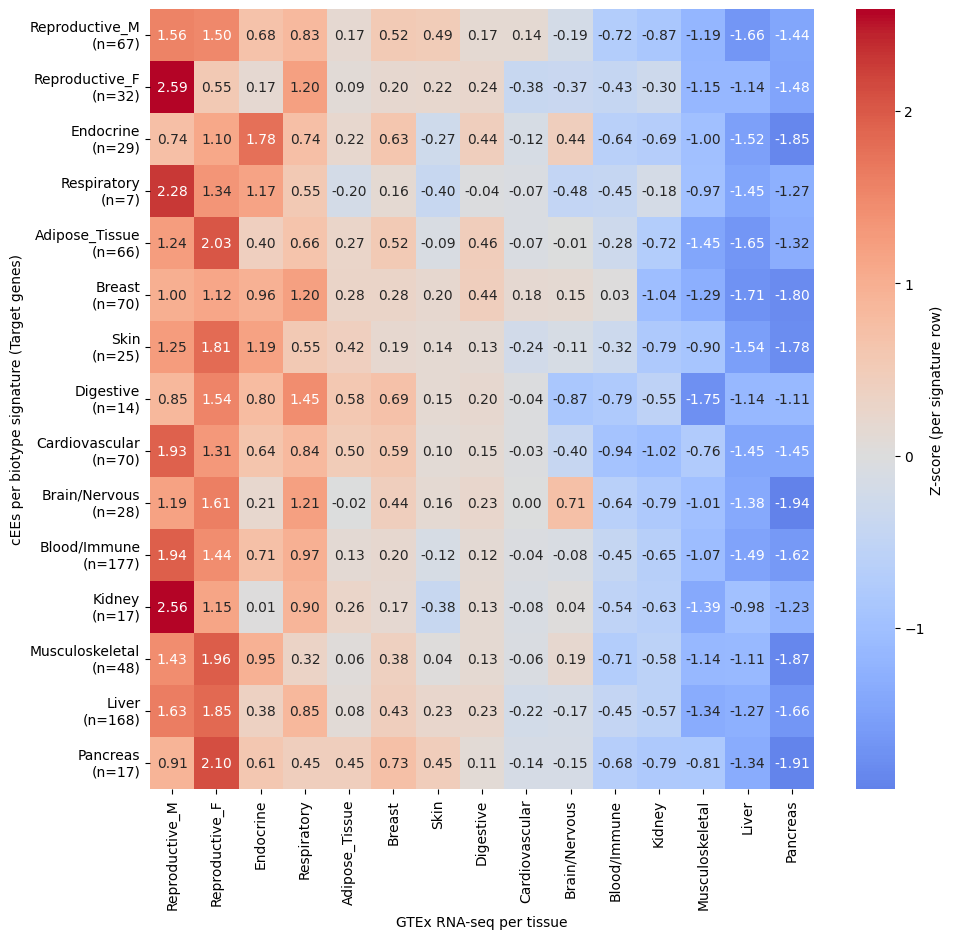

In [5]:
# take into account outliers 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(dataf)
df_exploded = df.explode('TPM')
df_exploded['TPM'] = pd.to_numeric(df_exploded['TPM'])

# Optional: limit to selected signature/tissue pairs
#df_exploded = df_exploded[df_exploded["Tissue"].isin(plot_tissues)]
#df_exploded = df_exploded[df_exploded["Signature"].isin(plot_tissues)]
df_exploded = df_exploded[df_exploded["Tissue"].isin(categories)]

def remove_outliers_iqr(group):
    Q1 = group['TPM'].quantile(0.25)
    Q3 = group['TPM'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['TPM'] >= Q1 - 1.5 * IQR) & (group['TPM'] <= Q3 + 1.5 * IQR)]

#df_no_outliers = df_exploded.groupby(['Signature', 'Tissue']).apply(remove_outliers_iqr).reset_index(drop=True)
#df_no_outliers['Tissue'] = pd.Categorical(df_no_outliers['Tissue'], categories=plot_tissues, ordered=True)
df_exploded['Tissue'] = pd.Categorical(df_exploded['Tissue'], categories=categories, ordered=True)

# Step 1: Group and pivot
heatmap_data = df_exploded.groupby(['Signature', 'Tissue'])['TPM'].median().reset_index()
heatmap_matrix = heatmap_data.pivot(index='Signature', columns='Tissue', values='TPM')

# Step 2: Build row sort key
sort_key = []
for signature in heatmap_matrix.index:
    row = heatmap_matrix.loc[signature]
    matching_value = row.get(signature, -1)  # get matching tissue value
    max_value = row.max()
    is_max = matching_value == max_value
    sort_key.append((is_max, matching_value, signature))

### SORT BY THE SAME ORDER AS HOST GENES 

# Step 3: Sort: (True first) then descending by matching value
#sorted_signatures = [sig for _, _, sig in sorted(sort_key, key=lambda x: (not x[0], -x[1]))]
sorted_signatures = ['Reproductive_M', 'Reproductive_F', 'Endocrine', 'Respiratory', 'Adipose_Tissue', 'Breast', 'Skin', 'Digestive', 'Cardiovascular', 'Brain/Nervous', 'Blood/Immune', 'Kidney', 'Musculoskeletal', 'Liver', 'Pancreas']


# Step 4: Reorder the matrix
heatmap_matrix = heatmap_matrix.loc[sorted_signatures]
ordered_columns = [col for col in sorted_signatures if col in heatmap_matrix.columns]
heatmap_matrix = heatmap_matrix[ordered_columns]

# --- Z-score normalization per row ---
heatmap_z = heatmap_matrix.copy()
heatmap_z = heatmap_z.subtract(heatmap_z.mean(axis=1), axis=0)
heatmap_z = heatmap_z.divide(heatmap_z.std(axis=1), axis=0)

# --- Plot Z-score heatmap ---
plt.figure(figsize=(10, 0.5 * len(heatmap_z) + 2))
ax = sns.heatmap(heatmap_z, annot=True, fmt=".2f", cmap="coolwarm", center=0,
                 cbar_kws={"label": "Z-score (per signature row)"})
#ax.set_title("Z-score Normalized Median TPM per Signature × Tissue")

yticklabels = ax.get_yticklabels()
new_labels = []

for tick in yticklabels:
    signature = tick.get_text()
    n = len(res_by_signature.get(signature, {}))
    new_labels.append(f"{signature}\n(n={n})")

ax.set_yticklabels(new_labels, rotation=0)

plt.ylabel("cEEs per biotype signature (Target genes)")
plt.xlabel("GTEx RNA-seq per tissue")
plt.tight_layout()

plt.savefig("/home/mouren/Images/revisions/rev_1_pt4_heatmap_target.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/revisions/rev_1_pt4_heatmap_target.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
